In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d jhe2918/cats-and-dogs-small

Dataset URL: https://www.kaggle.com/datasets/jhe2918/cats-and-dogs-small
License(s): unknown
 98% 85.0M/86.7M [00:04<00:00, 23.8MB/s]
100% 86.7M/86.7M [00:04<00:00, 18.7MB/s]


In [3]:
!unzip cats-and-dogs-small.zip -d /content/

Archive:  cats-and-dogs-small.zip
  inflating: /content/cats_and_dogs_small/test/cats/cat.1500.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1501.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1502.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1503.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1504.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1505.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1506.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1507.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1508.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1509.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1510.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1511.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1512.jpg  
  inflating: /content/cats_and_dogs_small/test/cats/cat.1513.jpg  
  inflating: /content/cats_a

In [4]:
!pip install keras-vis
!pip install tensorflow

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator (antiguo)
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import activations

# Utility Functions

In [7]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# Building a Convolutional Neural Network

## Model Definition

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#subir archivos
from google.colab import files
files.upload()

## Data Generator

In [9]:
base_dir = '/content/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Training

In [10]:
history = model.fit(train_generator, steps_per_epoch=100, epochs=20,
                              validation_data=validation_generator, validation_steps=20, verbose=1)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.4981 - loss: 0.7134 - val_accuracy: 0.4875 - val_loss: 0.6932
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5150 - val_loss: 0.6929
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5115 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5100 - val_loss: 0.6928
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.4690 - loss: 0.6940 - val_accuracy: 0.5075 - val_loss: 0.6915
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5108 - loss: 0.6935 - val_accuracy: 0.4675 - val_loss: 0.6929
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 

In [11]:
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Calcular el número de steps:
test_steps = len(test_generator)
results = model.evaluate(test_generator, steps=test_steps)

Found 1000 images belonging to 2 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6070 - loss: 0.6529


In [12]:
results ## --> loss, accuracy

[0.6479437351226807, 0.6309999823570251]

In [13]:
#model.save('model.h5') --> legacy, ahora se usa .keras
model.save('model.keras')

In [14]:
save_history(history, 'history.bin')

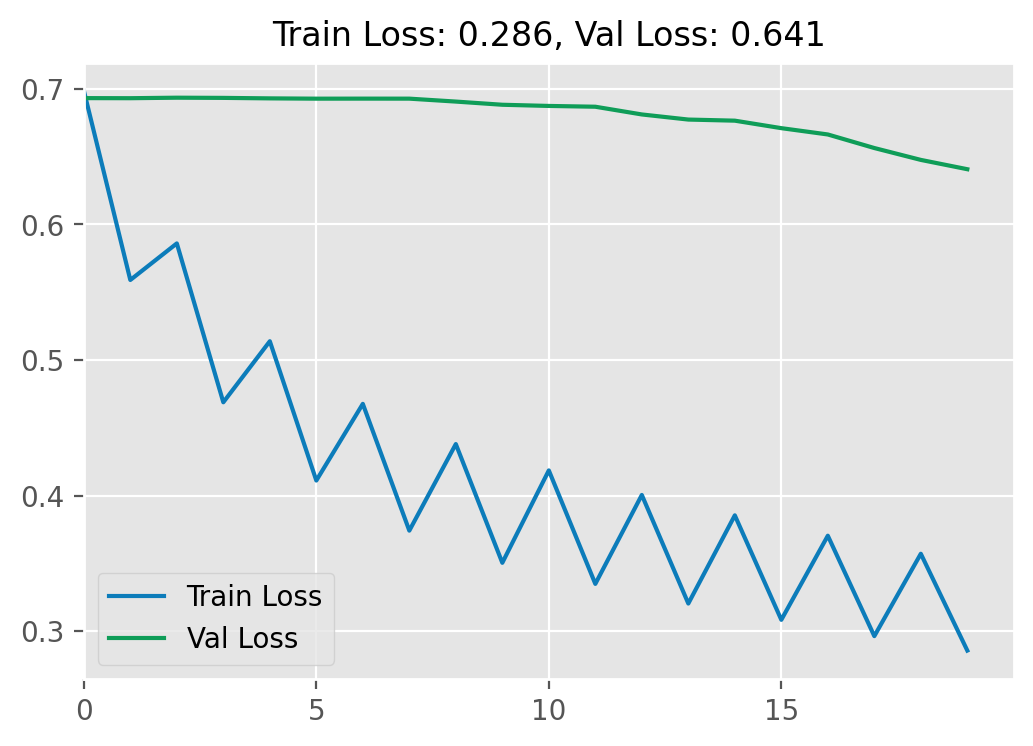

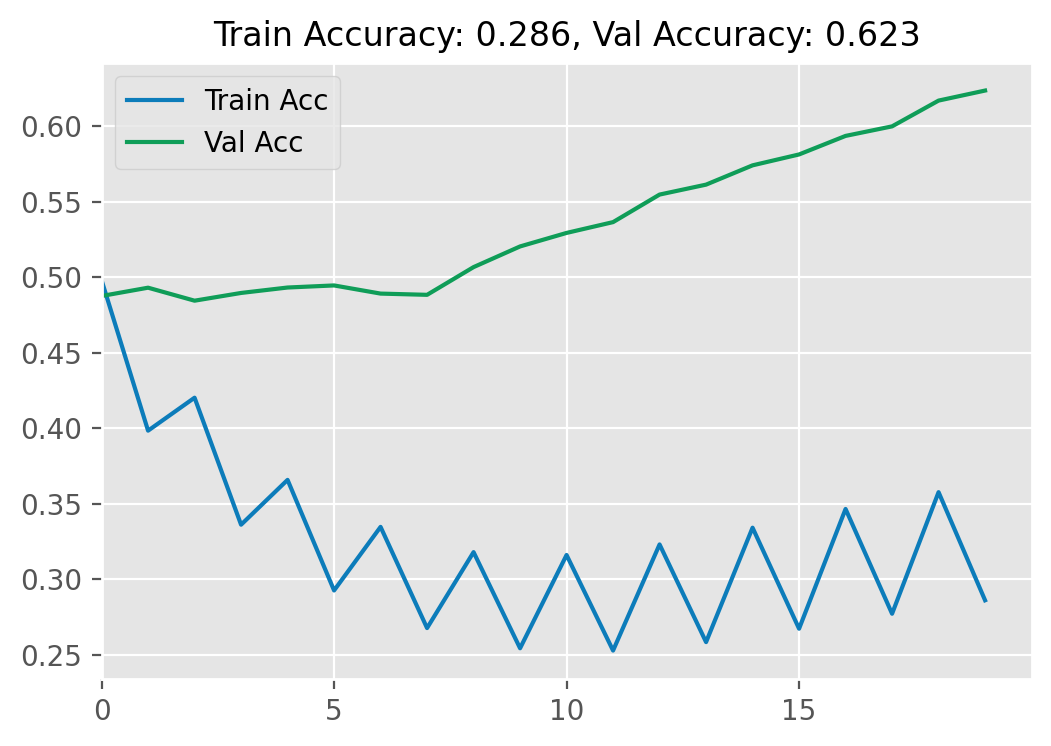

In [15]:
history = load_history('history.bin')
plot_compare(history)

## Data Augmentation

In [16]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(1, activation='sigmoid', name='output'))

In [17]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history_aug = model_aug.fit(train_generator, steps_per_epoch=100, epochs=20,
                                      validation_data=validation_generator, validation_steps=20, verbose=0)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
model_aug.save('model_aug.keras')
save_history(history_aug, 'history_aug.bin')

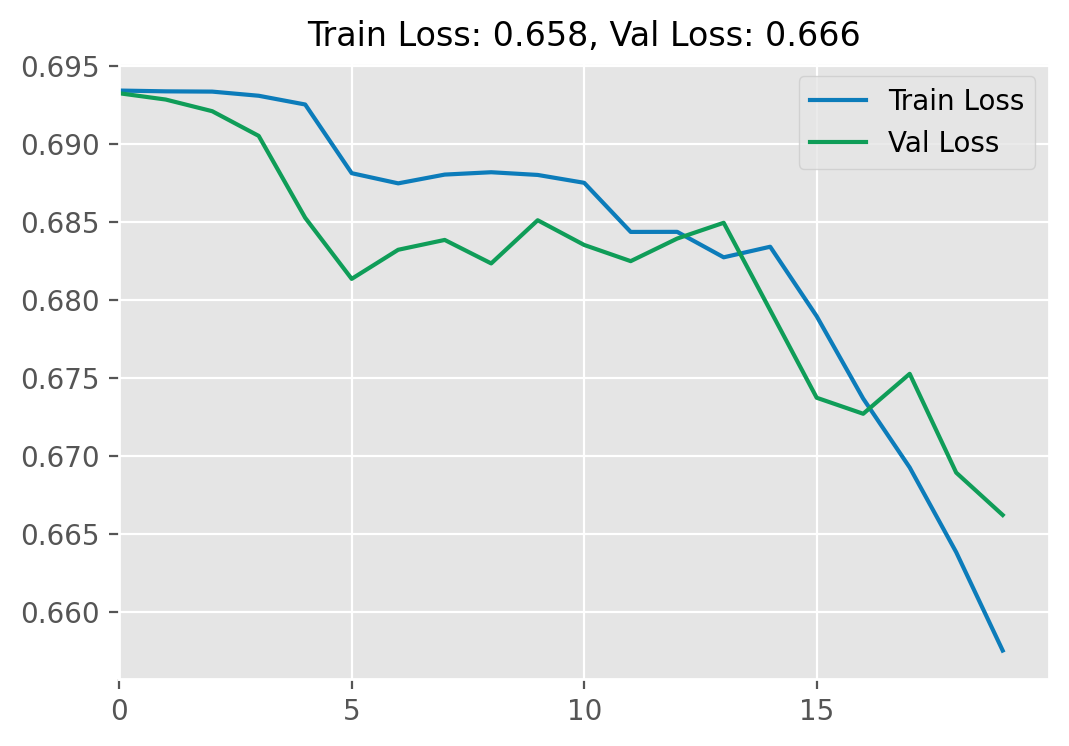

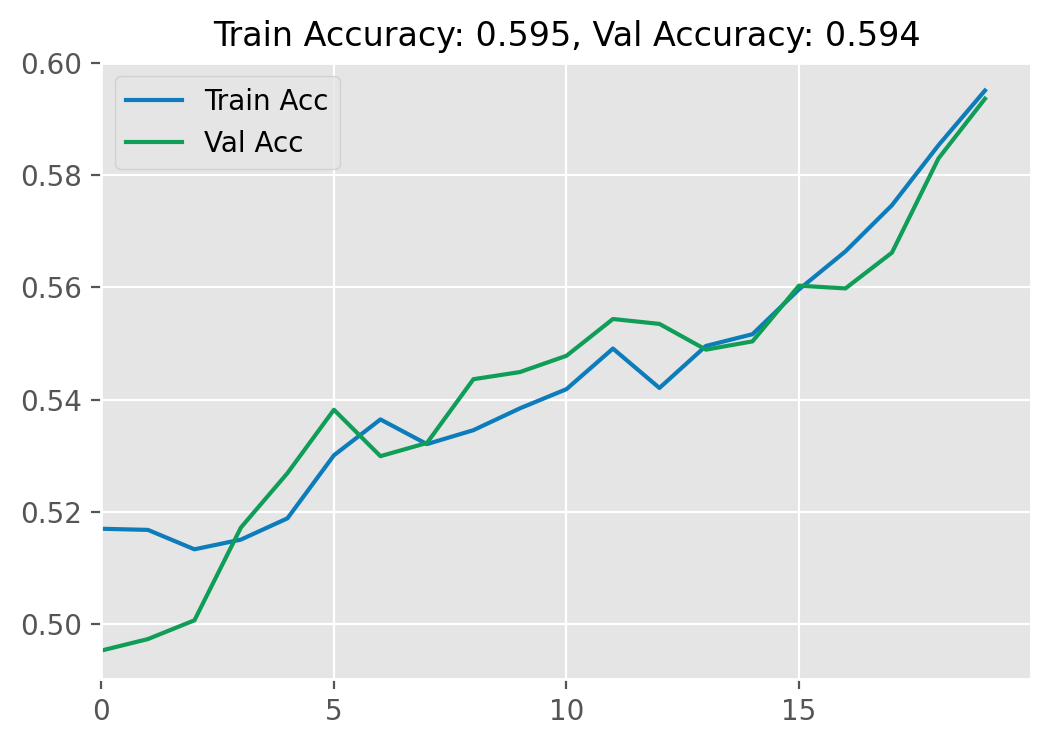

In [20]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug, steps=50)

In [21]:
# Calcular el número de steps:
results_aug = model_aug.evaluate(test_generator, steps=test_steps)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5654 - loss: 0.6619


# Visualizing Feature Maps

In [38]:
img_path = '/content/cats_and_dogs_small/train/cats/cat.128.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


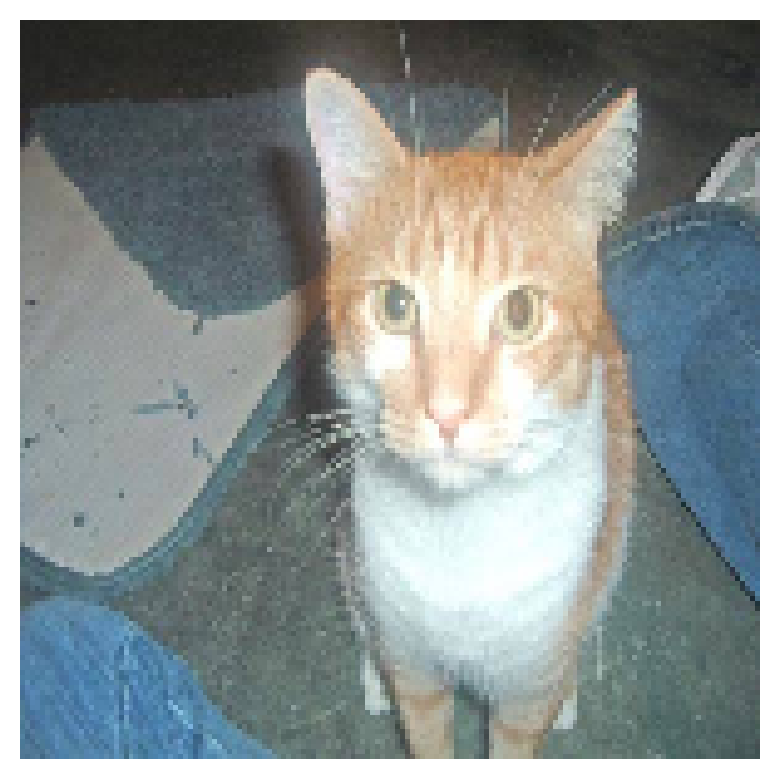

In [39]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [40]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


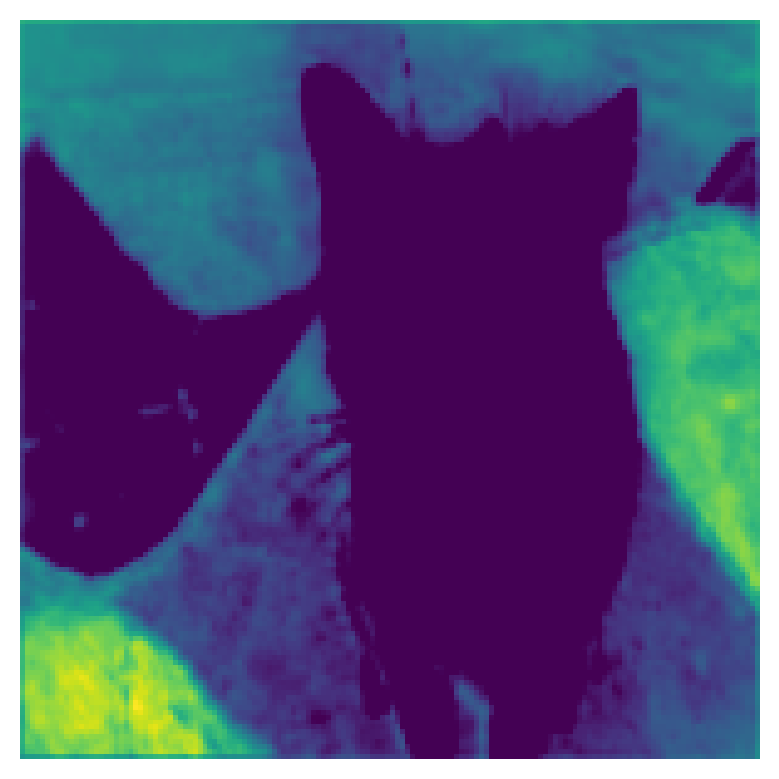

In [41]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


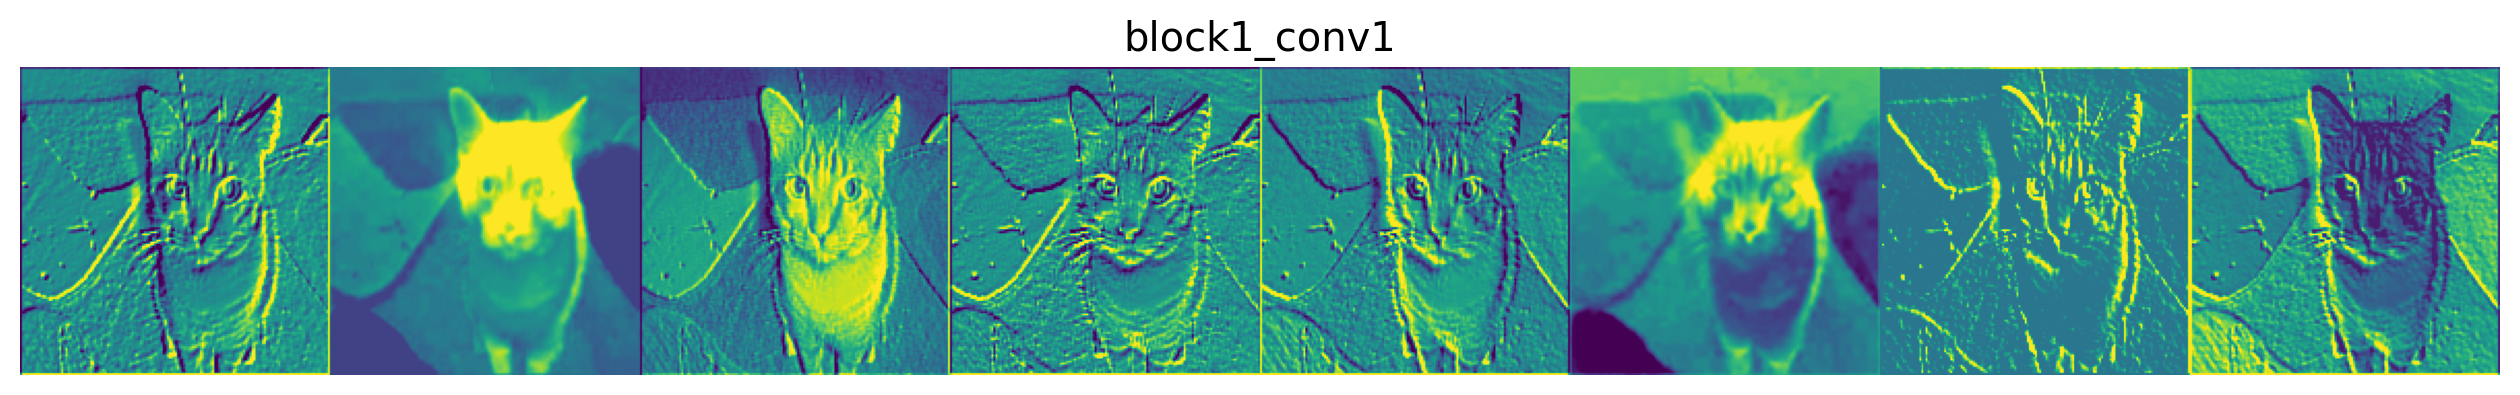

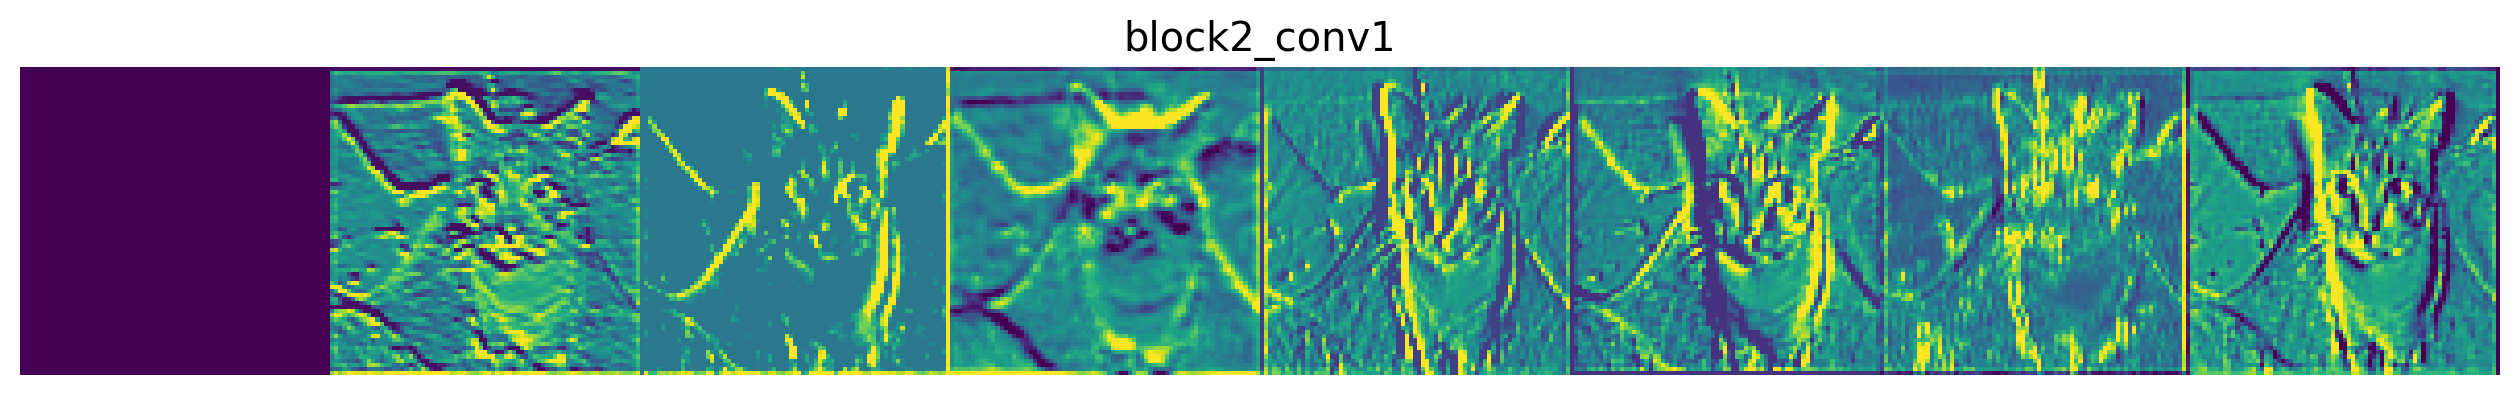

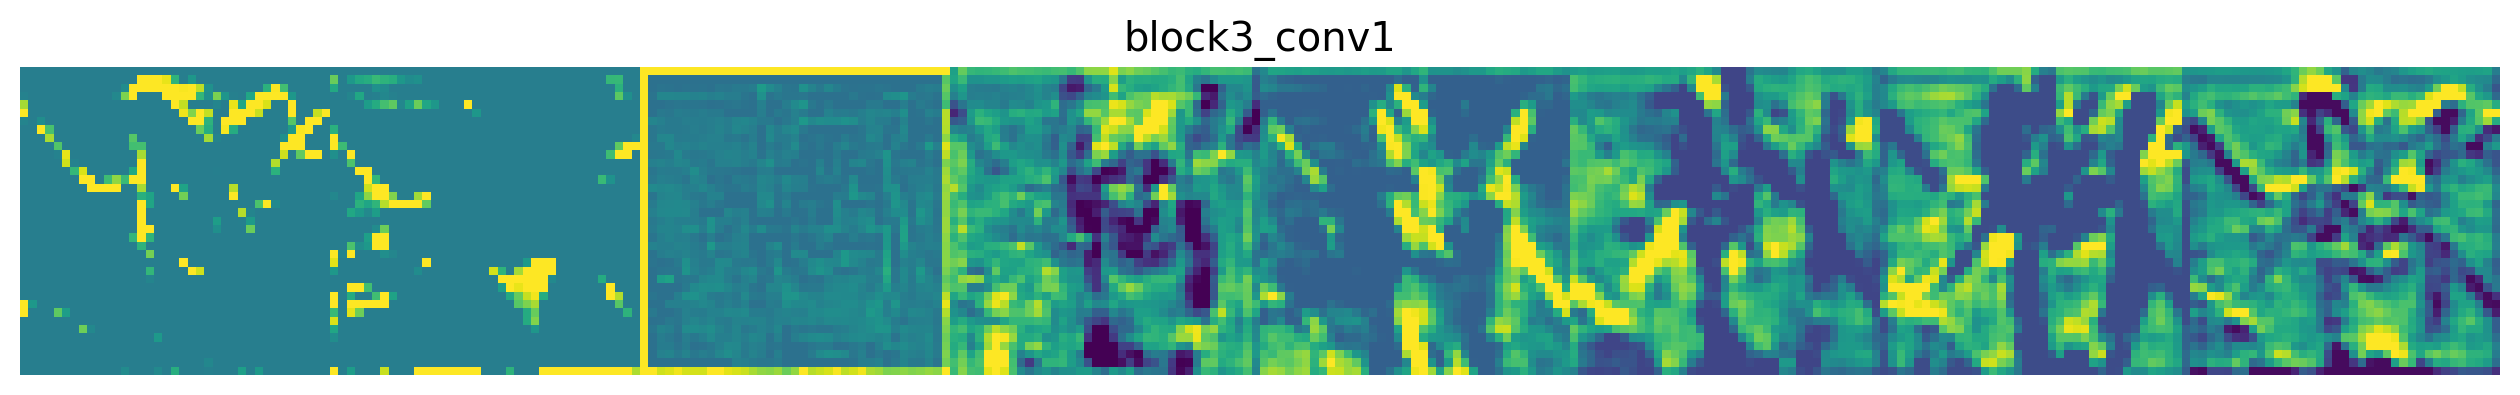

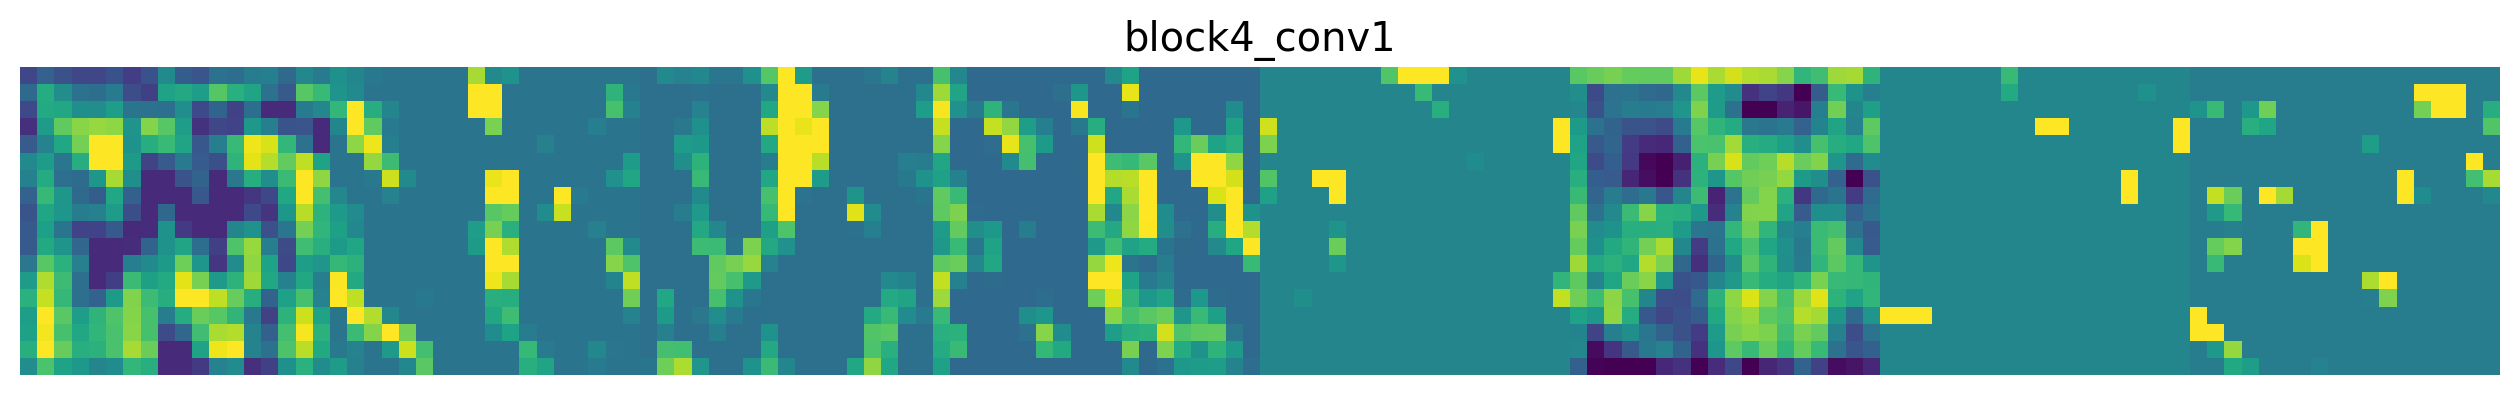

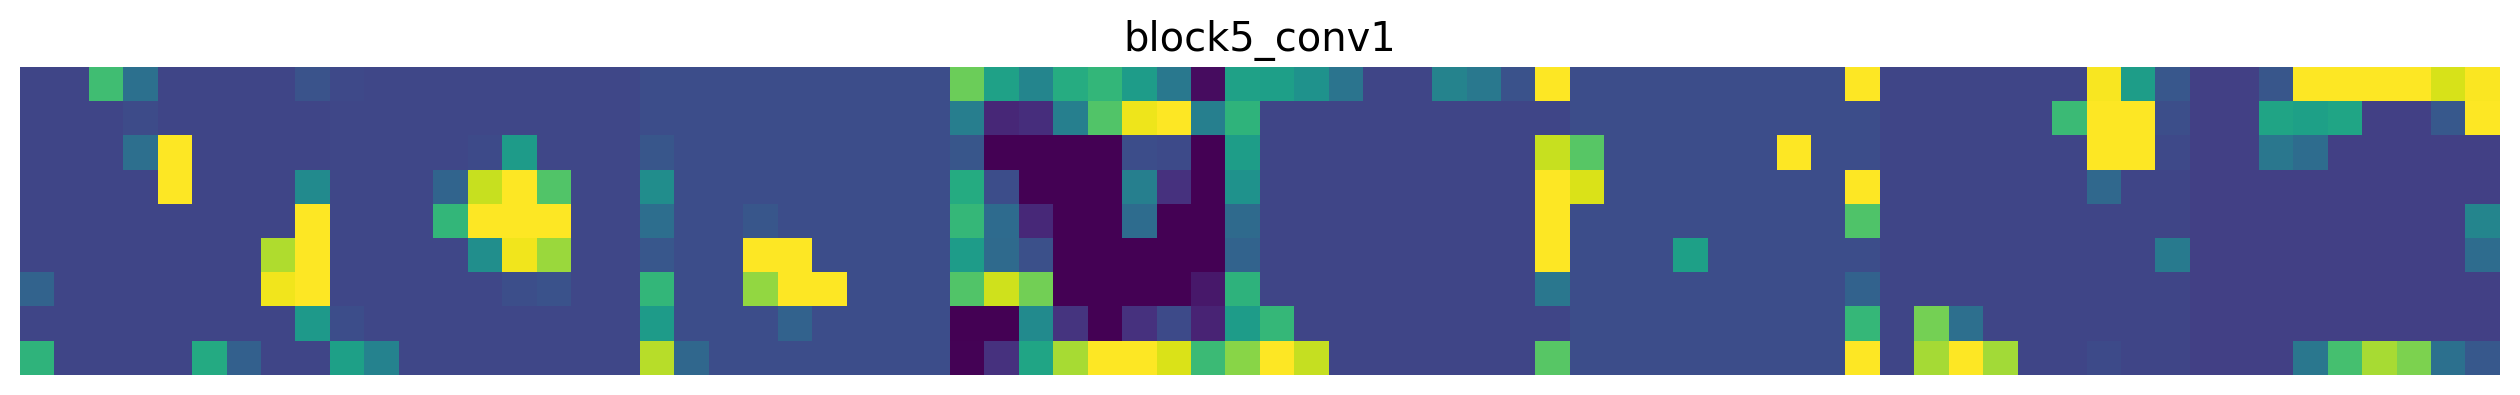

In [42]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

# Dense Layer Visualization

In [43]:
import inspect
import vis

# Obtener la ruta del archivo de la librería 'vis'
file_location = inspect.getfile(vis)
print(f"La librería 'vis' está ubicada en: {file_location}")

La librería 'vis' está ubicada en: /usr/local/lib/python3.10/dist-packages/vis/__init__.py


In [44]:
# Cambiar la línea que contiene 'from collections import Iterable'
file_path="/usr/local/lib/python3.10/dist-packages/vis/utils/utils.py"
line_number = 15  # Cambia esto al número de línea correcto
new_line = 'from collections.abc import Iterable\n'

# Reemplazar la línea en el archivo
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[line_number - 1] = new_line

with open(file_path, 'w') as file:
  file.writelines(lines)

In [45]:
from vis.utils import utils
#from vis.visualization import visualize_activation, get_num_filters
#from vis.input_modifiers import Jitter

In [46]:
# Build the VGG16 network with ImageNet weights
model_2 = VGG16(weights='imagenet', include_top=True)

In [47]:
# Utility to search for layer index by name.
layer_idx = utils.find_layer_idx(model_2, 'block1_conv1')
print(layer_idx)

1


In [48]:
model_2.summary() #include_top=True, que incluye la capa de clasificación final.

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Obtener la capa de salida
output_layer = model_2.layers[-1]

# Comprobar la activación
print(f"Nombre de la capa: {output_layer.name}")
print(f"Función de activación: {output_layer.activation}")

Nombre de la capa: predictions
Función de activación: <function softmax at 0x795c7da58700>


# **Cambiar última capa a Activación Linear**
Cambiar a linear en la capa de salida permite optimizar la entrada para maximizar la activación del filtro

In [54]:
from tensorflow.keras import layers, models, activations

# Extraer todas las capas excepto la capa de salida
x = model.layers[-2].output  # Salida de la penúltima capa

# Crear una nueva capa de salida con activación lineal
predictions = layers.Dense(1000, activation='linear', name='predictions')(x)

# Crear un nuevo modelo con la capa de salida modificada
modified_model = models.Model(inputs=model_2.input, outputs=predictions)

In [55]:
# Ajusta el optimizador y la función de pérdida según sea necesario
modified_model.compile(optimizer='adam', loss='mean_squared_error')

In [56]:
# Obtener la capa de salida
output_layer = modified_model.layers[-1]

# Comprobar la activación de softmax --> linear
print(f"Nombre de la capa: {output_layer.name}")
print(f"Función de activación: {output_layer.activation}")

Nombre de la capa: predictions
Función de activación: <function linear at 0x795c7da58dc0>


In [57]:
pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.5 MB/s eta 0:00:00


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import backend as K

def visualize_activation(model, layer_name, input_image, num_rows=8, num_cols=None):
    """
    Visualize the activation of a specific layer for a given input image.
    """
    # Create a model that outputs the activations of the target layer
    layer_output = model.get_layer(layer_name).output
    activation_model = models.Model(inputs=model.input, outputs=layer_output)

    # Get the activations
    activations = activation_model.predict(np.expand_dims(input_image, axis=0))

    # Normalize activations for better visualization
    activations -= activations.mean()
    activations /= activations.std()

    num_filters = activations.shape[-1]
    size = activations.shape[1]

    if num_cols is None:
        num_cols = num_filters // num_rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_filters):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(activations[0, :, :, i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')

    plt.suptitle(f'Activations for layer {layer_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load a pre-trained model
model = VGG16(weights='imagenet', include_top=True)

# Load an image and preprocess it
img_path = '/content/cats_and_dogs_small/test/cats/cat.1500.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)

# Visualize the activation of a specific layer
layer_name = 'block5_conv3'  # Example layer name
visualize_activation(model, layer_name, img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


In [69]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Reemplaza 'ruta_a_tu_imagen.jpg' con la ruta a tu archivo de imagen.
img_path = '/content/cats_and_dogs_small/test/cats/cat.1505.jpg'

try:
    # Cargar la imagen con tamaño 224x224, que es el tamaño esperado por VGG16.
    img = image.load_img(img_path, target_size=(224, 224))

    # Convertir la imagen a un array de numpy (con forma de 3 dimensiones: ancho, alto, canales de color).
    img_array = image.img_to_array(img)

    # Expandir dimensiones para tener la forma (1, 224, 224, 3) como VGG16 espera.
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocesar la imagen para que sea compatible con el modelo VGG16 (normalización, etc.).
    img_array = preprocess_input(img_array)

    print("La imagen ha sido procesada correctamente.")

except Exception as e:
    print(f"Ocurrió un error al procesar la imagen: {e}")


La imagen ha sido procesada correctamente.


In [62]:
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions

# Cargar el modelo VGG16 preentrenado con pesos de ImageNet
model = VGG16(weights='imagenet')

# Hacer una predicción sobre la imagen
predictions = model.predict(img_array)

# Decodificar las predicciones para obtener nombres de clases legibles
decoded_predictions = decode_predictions(predictions, top=3)[0]
print("Predicciones:", decoded_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
Predicciones: [('n02123045', 'tabby', 0.13450557), ('n02123394', 'Persian_cat', 0.10290937), ('n03255030', 'dumbbell', 0.031890295)]


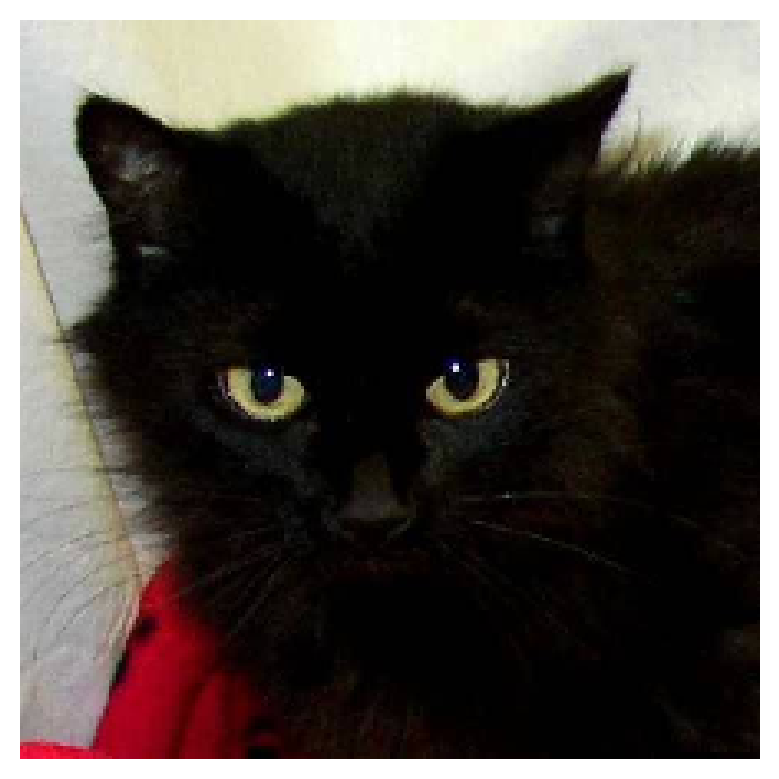

Predicción: tabby, Probabilidad: 0.13450556993484497
Predicción: Persian_cat, Probabilidad: 0.10290937125682831
Predicción: dumbbell, Probabilidad: 0.03189029544591904


In [64]:
import matplotlib.pyplot as plt

# Mostrar la imagen original
plt.imshow(image.load_img(img_path, target_size=(224, 224)))
plt.axis('off')
plt.show()

# Mostrar las predicciones
for pred in decoded_predictions:
    print(f"Predicción: {pred[1]}, Probabilidad: {pred[2]}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - Score: 67.3966 - TotalVariation2D: 6.8175 - Norm: 26.9188


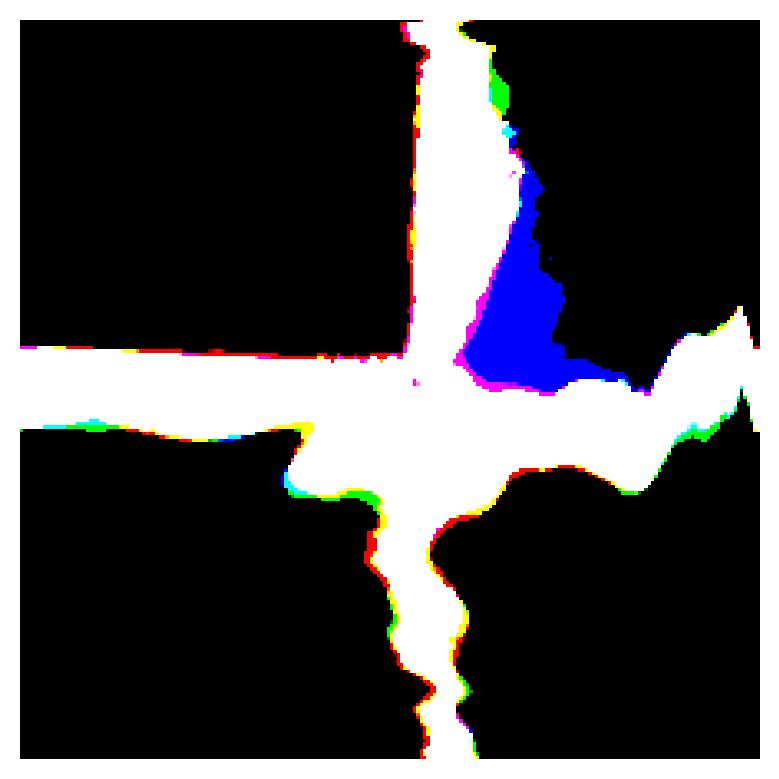

In [65]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress

# Reemplazar la última capa softmax por una capa lineal para visualización
replace2linear = ReplaceToLinear()

# Seleccionar una categoría específica para maximización de activación
# Puedes usar una categoría que haya sido predicha en el paso anterior
categoria_elegida = np.argmax(predictions)
score = CategoricalScore(categoria_elegida)

# Crear instancia de ActivationMaximization
activation_maximization = ActivationMaximization(model, model_modifier=replace2linear, clone=True)

# Visualizar las activaciones
activations = activation_maximization(score, seed_input=img_array, callbacks=[Progress()])

# Mostrar la imagen que maximiza la activación de la categoría seleccionada
plt.imshow(activations[0])
plt.axis('off')
plt.show()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - Score: 407.6808 - TotalVariation2D: 10.1354 - Norm: 19.0109


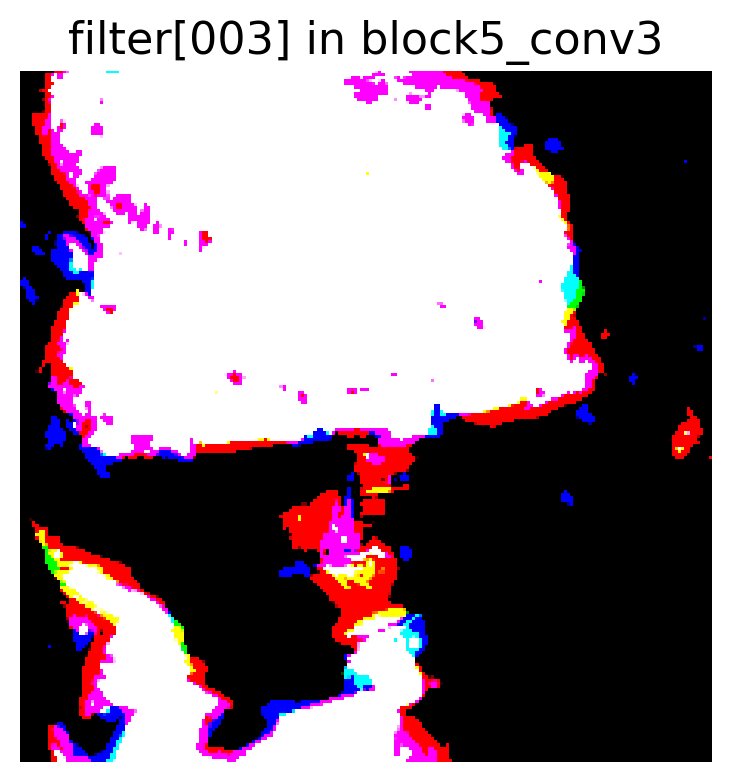

In [68]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress

# Cargar el modelo VGG16 preentrenado con pesos de ImageNet
model = Model(weights='imagenet', include_top=True)
model.summary()

# Parámetros
layer_name = 'block5_conv3'  # Capa objetivo
filter_number = 3  # Número del filtro a visualizar
img_path = '/content/cats_and_dogs_small/test/cats/cat.1503.jpg'  # Ruta de la imagen

try:
    # Modificar el modelo para que apunte a la capa de interés
    extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
    replace2linear = ReplaceToLinear()

    # Crear instancia de ActivationMaximization
    activation_maximization = ActivationMaximization(
        model,
        model_modifier=[extract_intermediate_layer, replace2linear],
        clone=False
    )

    # Función de puntuación para maximizar el filtro específico
    score = CategoricalScore(filter_number)

    # Cargar y preprocesar la imagen
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Utilizar la imagen cargada como seed_input
    seed_input = img_array

    # Generar activación maximizada
    activations = activation_maximization(score, seed_input=seed_input, callbacks=[Progress()])

    # Visualizar la activación
    f, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(activations[0])
    ax.set_title(f'filter[{filter_number:03d}] in {layer_name}', fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Ocurrió un error durante la generación o visualización de activaciones: {e}")
